In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import time

In [2]:
# Helper function
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

In [3]:
# Load data
mnist_data = fetch_openml("mnist_784", parser='auto')
x = mnist_data["data"].astype(np.float32)
y = mnist_data["target"].astype(np.int32)

# Normalize
x /= 255.0

In [4]:
# One-hot encode labels
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

num_labels = 10
y_one_hot = one_hot_encode(y, num_labels)

In [5]:
train_size = 60000
test_size = x.shape[0] - train_size
x_train, x_test = x[:train_size].to_numpy(), x[train_size:].to_numpy()
y_train, y_test = y_one_hot[:train_size], y_one_hot[train_size:]

shuffle_index = np.random.permutation(train_size)
x_train = x_train[shuffle_index]
y_train = y_train[shuffle_index]


Training data: (60000, 784) (60000, 10)
Test data: (10000, 784) (10000, 10)


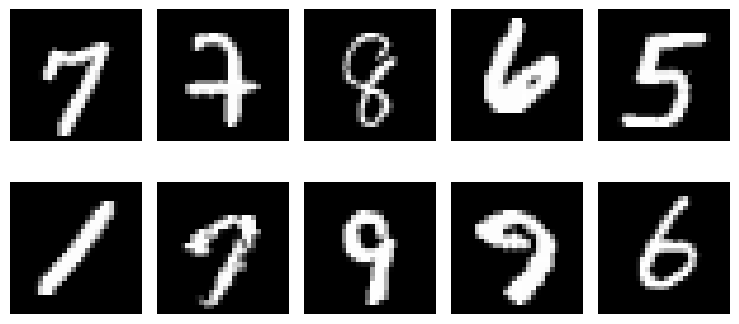

In [6]:
print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))
show_images(x_train)

In [7]:
class DeepNeuralNetwork():
    def __init__(self, sizes, activation='sigmoid'):
        self.sizes = sizes
        
        # Choose activation function
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        else:
            raise ValueError("Activation function is currently not support, please use 'relu' or 'sigmoid' instead.")
        
        # Save all weights
        self.params = self.initialize()
        # Save all intermediate values, i.e. activations
        self.cache = {}
        
    def relu(self, x, derivative=False):
        '''
            Derivative of ReLU is a bit more complicated since it is not differentiable at x = 0
        
            Forward path:
            relu(x) = max(0, x)
            In other word,
            relu(x) = 0, if x < 0
                    = x, if x >= 0

            Backward path:
            ∇relu(x) = 0, if x < 0
                     = 1, if x >=0
        '''
        if derivative:
            x = np.where(x < 0, 0, x)
            x = np.where(x >= 0, 1, x)
            return x
        return np.maximum(0, x)

    def sigmoid(self, x, derivative=False):
        '''
            Forward path:
            σ(x) = 1 / 1+exp(-z)
            
            Backward path:
            ∇σ(x) = exp(-z) / (1+exp(-z))^2
        '''
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x):
        '''
            softmax(x) = exp(x) / ∑exp(x)
        '''
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)

    def initialize(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_layer=self.sizes[1]
        output_layer=self.sizes[2]
        
        params = {
            "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1./input_layer),
            "b1": np.zeros((hidden_layer, 1)) * np.sqrt(1./input_layer),
            "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1./hidden_layer),
            "b2": np.zeros((output_layer, 1)) * np.sqrt(1./hidden_layer)
        }
        return params
    
    def initialize_momemtum_optimizer(self):
        momemtum_opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }
        return momemtum_opt

    def feed_forward(self, x):
        '''
            y = σ(wX + b)
        '''
        self.cache["X"] = x
        self.cache["Z1"] = np.matmul(self.params["W1"], self.cache["X"].T) + self.params["b1"]
        self.cache["A1"] = self.activation(self.cache["Z1"])
        self.cache["Z2"] = np.matmul(self.params["W2"], self.cache["A1"]) + self.params["b2"]
        self.cache["A2"] = self.softmax(self.cache["Z2"])
        return self.cache["A2"]
    
    def back_propagate(self, y, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        current_batch_size = y.shape[0]
        
        dZ2 = output - y.T
        dW2 = (1./current_batch_size) * np.matmul(dZ2, self.cache["A1"].T)
        db2 = (1./current_batch_size) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.matmul(self.params["W2"].T, dZ2)
        dZ1 = dA1 * self.activation(self.cache["Z1"], derivative=True)
        dW1 = (1./current_batch_size) * np.matmul(dZ1, self.cache["X"])
        db1 = (1./current_batch_size) * np.sum(dZ1, axis=1, keepdims=True)

        self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
        return self.grads
    
    def cross_entropy_loss(self, y, output):
        '''
            L(y, ŷ) = −∑ylog(ŷ).
        '''
        l_sum = np.sum(np.multiply(y.T, np.log(output)))
        m = y.shape[0]
        l = -(1./m) * l_sum
        return l
                
    def optimize(self, l_rate=0.1, beta=.9):
        '''
            Stochatic Gradient Descent (SGD):
            θ^(t+1) <- θ^t - η∇L(y, ŷ)
            
            Momentum:
            v^(t+1) <- βv^t + (1-β)∇L(y, ŷ)^t
            θ^(t+1) <- θ^t - ηv^(t+1)
        '''
        if self.optimizer == "sgd":
            for key in self.params:
                self.params[key] = self.params[key] - l_rate * self.grads[key]
        elif self.optimizer == "momentum":
            for key in self.params:
                self.momemtum_opt[key] = (beta * self.momemtum_opt[key] + (1. - beta) * self.grads[key])
                self.params[key] = self.params[key] - l_rate * self.momemtum_opt[key]
        else:
            raise ValueError("Optimizer is currently not support, please use 'sgd' or 'momentum' instead.")

    def accuracy(self, y, output):
        return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis=-1))

    def train(self, x_train, y_train, x_test, y_test, epochs=10, 
              batch_size=64, optimizer='momentum', l_rate=0.1, beta=.9):
        self.epochs = epochs
        self.batch_size = batch_size
        num_batches = -(-x_train.shape[0] // self.batch_size)
        
        self.optimizer = optimizer
        if self.optimizer == 'momentum':
            self.momemtum_opt = self.initialize_momemtum_optimizer()
        
        train_accuracies = []
        test_accuracies = []

        start_time = time.time()
        template = "Epoch {}: {:.2f}s, train acc={:.2f}, train loss={:.2f}, test acc={:.2f}, test loss={:.2f}"
        
        for i in range(self.epochs):
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for j in range(num_batches):
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0]-1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]
                
                output = self.feed_forward(x)
                grad = self.back_propagate(y, output)
                self.optimize(l_rate=l_rate, beta=beta)

            output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, output)
            train_loss = self.cross_entropy_loss(y_train, output)

            output = self.feed_forward(x_test)
            test_acc = self.accuracy(y_test, output)
            test_loss = self.cross_entropy_loss(y_test, output)

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            print(template.format(i+1, time.time()-start_time, train_acc, train_loss, test_acc, test_loss))
        
        return train_accuracies, test_accuracies

In [8]:
# Sigmoid + Momentum
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
train_acc, test_acc_dnn = dnn.train(x_train, y_train, x_test, y_test, epochs=10, optimizer='momentum', l_rate=0.1, beta=.9)

Epoch 1: 1.69s, train acc=0.89, train loss=0.42, test acc=0.89, test loss=0.41
Epoch 2: 2.90s, train acc=0.91, train loss=0.33, test acc=0.91, test loss=0.32
Epoch 3: 4.22s, train acc=0.92, train loss=0.29, test acc=0.92, test loss=0.28
Epoch 4: 5.42s, train acc=0.93, train loss=0.26, test acc=0.93, test loss=0.26
Epoch 5: 6.69s, train acc=0.93, train loss=0.24, test acc=0.93, test loss=0.24
Epoch 6: 8.09s, train acc=0.93, train loss=0.23, test acc=0.93, test loss=0.23
Epoch 7: 9.07s, train acc=0.94, train loss=0.22, test acc=0.94, test loss=0.22
Epoch 8: 10.28s, train acc=0.94, train loss=0.20, test acc=0.94, test loss=0.21
Epoch 9: 11.40s, train acc=0.95, train loss=0.19, test acc=0.94, test loss=0.19
Epoch 10: 12.53s, train acc=0.95, train loss=0.18, test acc=0.94, test loss=0.19


In [9]:
# ReLU + SGD
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='sgd', l_rate=0.05)

Epoch 1: 0.68s, train acc=0.89, train loss=0.40, test acc=0.90, test loss=0.38
Epoch 2: 1.35s, train acc=0.90, train loss=0.33, test acc=0.91, test loss=0.31
Epoch 3: 2.28s, train acc=0.91, train loss=0.30, test acc=0.92, test loss=0.29
Epoch 4: 2.95s, train acc=0.92, train loss=0.28, test acc=0.92, test loss=0.27
Epoch 5: 3.60s, train acc=0.92, train loss=0.28, test acc=0.93, test loss=0.27
Epoch 6: 4.30s, train acc=0.92, train loss=0.26, test acc=0.93, test loss=0.26
Epoch 7: 5.04s, train acc=0.93, train loss=0.26, test acc=0.93, test loss=0.25
Epoch 8: 5.75s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 9: 6.42s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 10: 7.08s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25


([0.8880166666666667,
  0.90485,
  0.9138166666666667,
  0.9179666666666667,
  0.9202666666666667,
  0.9236833333333333,
  0.9257833333333333,
  0.92705,
  0.9286166666666666,
  0.9289333333333334],
 [0.8953, 0.912, 0.9167, 0.9235, 0.925, 0.9257, 0.926, 0.9254, 0.9272, 0.9278])

## TENSORFLOW

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
import numpy as np

In [11]:
# Load the MNIST dataset
mnist_data = fetch_openml("mnist_784", parser='auto')
X, y = mnist_data["data"].astype(np.int64), mnist_data["target"].astype(np.int64)

In [12]:
# Convert the labels to integers
y = y.astype(np.int64)

# Normalize the input data
X = X / 255.0

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Build the neural network model
model = models.Sequential([
    layers.InputLayer(input_shape=(784,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history_tf = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy (TensorFlow): {test_acc}")

Epoch 1/10


2024-06-25 10:32:52.514256: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1400/1400 [==============================] - 2s 1ms/step - loss: 0.3213 - accuracy: 0.9040 - val_loss: 0.1558 - val_accuracy: 0.9515
Epoch 2/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.1497 - accuracy: 0.9532 - val_loss: 0.1205 - val_accuracy: 0.9630
Epoch 3/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.1150 - accuracy: 0.9638 - val_loss: 0.0995 - val_accuracy: 0.9694
Epoch 4/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0938 - accuracy: 0.9696 - val_loss: 0.0937 - val_accuracy: 0.9721
Epoch 5/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0811 - accuracy: 0.9739 - val_loss: 0.1012 - val_accuracy: 0.9685
Epoch 6/10
1400/1400 [==============================] - 1s 1ms/step - loss: 0.0734 - accuracy: 0.9758 - val_loss: 0.0810 - val_accuracy: 0.9755
Epoch 7/10
1400/1400 [==============================] - 1s 1ms/step - loss: 0.0616 - accuracy: 0.9800 - val_loss: 0.1021 - val_accuracy: 0.9710
Epo

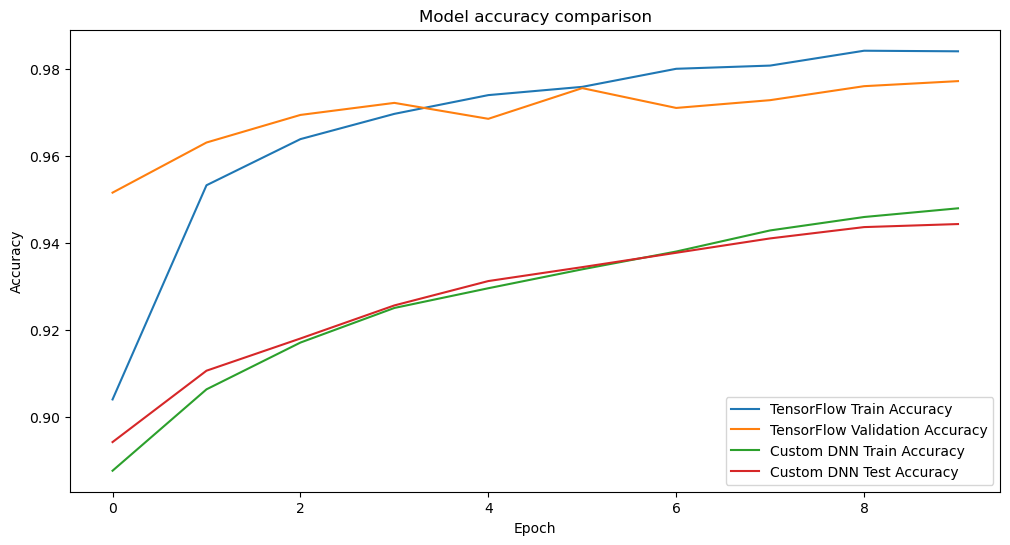

In [14]:
plt.figure(figsize=(12, 6))

# TensorFlow Model
plt.plot(history_tf.history['accuracy'], label='TensorFlow Train Accuracy')
plt.plot(history_tf.history['val_accuracy'], label='TensorFlow Validation Accuracy')

# Custom DNN Model
plt.plot(train_acc, label='Custom DNN Train Accuracy')
plt.plot(test_acc_dnn, label='Custom DNN Test Accuracy')

plt.title('Model accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()